Імпортуємо усі необхідні бібліотеки:

In [ ]:
import pandas as pd
import numpy as np
from numpy import sqrt

import matplotlib.pyplot as plt
import seaborn as sb

from sqlalchemy.engine import URL
from sqlalchemy import create_engine

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

Завантажимо усі дані з сховища даних у датафрейм:

In [60]:
connection_string = 'DRIVER={SQL Server};SERVER=LAPTOP-2T0TBBUP\SQLEXPRESS;DATABASE=MoviesDB;Trusted_Connection=yes'
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)
query = "SELECT * FROM moviesAnalysisWithAge"
movies = pd.read_sql(query, engine)

movies.info()
movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8276 non-null   int64  
 1   Name             8276 non-null   object 
 2   Genres           8276 non-null   object 
 3   RatingName       8276 non-null   object 
 4   Year             8276 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      8276 non-null   int64  
 7   NominatedNumber  8276 non-null   int64  
 8   Gross            7383 non-null   float64
 9   Budget           7383 non-null   float64
 10  DurationMinutes  8263 non-null   float64
 11  VotesNumber      8200 non-null   float64
 12  ImbdScore        8248 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 840.7+ KB


,id,Name,Genres,RatingName,Year,Month,OscarWinSum,NominatedNumber,Gross,Budget,DurationMinutes,VotesNumber,ImbdScore
0,1,#Saraitda,Action-Drama-Horror,TV-MA,2020,None,0,0,NaN,NaN,98.0,32671.0,6.3
1,2,(500) Days of Summer,Romance-Drama-Comedy,PG-13,2009,None,0,0,NaN,NaN,95.0,489549.0,7.7
2,3,*batteries not included,Comedy,PG,1987,December,0,0,65088797.0,25000000.0,106.0,32000000.0,6.7
3,4,[Rec],Thriller-Horror-Mystery,R,2007,None,0,0,NaN,NaN,78.0,172050.0,7.4
4,5,[Rec]²,Horror,R,2009,October,0,0,18853164.0,5600000.0,85.0,70000000.0,6.5


Оберемо стовпці, які буду факторами, а який буде відгуком. Ми хочемо прогнозувати прибутки фільму, тому оберемо прибуток як відгук, а інші стовпці будуть факторами:

In [63]:
factors = ['Year', 'OscarWinSum', 'NominatedNumber', 'Budget', 'DurationMinutes', 'VotesNumber', 'ImbdScore', 'Genres', 'RatingName']
response = 'Gross'

Проведемо обробку даних. Спочатку перевіримо, чи має дата фрейм пропущені значення:

In [20]:
movies.isnull().values.any()

True

Видалимо усі фільми, які не мають відгуку(касових зборів):

In [64]:
movies = movies.loc[movies['Gross'].notna() != 0]
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383 entries, 2 to 8274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7383 non-null   int64  
 1   Name             7383 non-null   object 
 2   Genres           7383 non-null   object 
 3   RatingName       7383 non-null   object 
 4   Year             7383 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      7383 non-null   int64  
 7   NominatedNumber  7383 non-null   int64  
 8   Gross            7383 non-null   float64
 9   Budget           7383 non-null   float64
 10  DurationMinutes  7383 non-null   float64
 11  VotesNumber      7339 non-null   float64
 12  ImbdScore        7383 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 807.5+ KB


Заповнимо усі пропущені числові значення середніми:

In [66]:
numeric_columns = movies.select_dtypes(include=['number']).columns
means = movies[numeric_columns].mean()
movies[numeric_columns] = movies[numeric_columns].fillna(means)

movies.info()
movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383 entries, 2 to 8274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7383 non-null   int64  
 1   Name             7383 non-null   object 
 2   Genres           7383 non-null   object 
 3   RatingName       7383 non-null   object 
 4   Year             7383 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      7383 non-null   int64  
 7   NominatedNumber  7383 non-null   int64  
 8   Gross            7383 non-null   float64
 9   Budget           7383 non-null   float64
 10  DurationMinutes  7383 non-null   float64
 11  VotesNumber      7383 non-null   float64
 12  ImbdScore        7383 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 807.5+ KB


<ipython-input-66-d88ddc1ad568>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[numeric_columns] = movies[numeric_columns].fillna(means)


,id,Name,Genres,RatingName,Year,Month,OscarWinSum,NominatedNumber,Gross,Budget,DurationMinutes,VotesNumber,ImbdScore
2,3,*batteries not included,Comedy,PG,1987,December,0,0,65088797.0,25000000.0,106.0,32000000.0,6.7
4,5,[Rec]²,Horror,R,2009,October,0,0,18853164.0,5600000.0,85.0,70000000.0,6.5
6,7,10 Cloverfield Lane,Action-Drama-Horror,PG-13,2016,March,0,0,110216998.0,15000000.0,103.0,306304.0,7.2
7,8,10 Things I Hate About You,Romance-Drama-Comedy,PG-13,1999,March,0,0,53478579.0,30000000.0,97.0,315247.0,7.3
8,9,10 to Midnight,Crime,R,1983,March,0,0,7175592.0,4520000.0,101.0,7200000.0,6.3


Видалимо усі фільми, які мають пропущені текстові значення:

In [68]:
movies.dropna(inplace=True)

movies.info()
movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7374 non-null   int64  
 1   Name             7374 non-null   object 
 2   Genres           7374 non-null   object 
 3   RatingName       7374 non-null   object 
 4   Year             7374 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      7374 non-null   int64  
 7   NominatedNumber  7374 non-null   int64  
 8   Gross            7374 non-null   float64
 9   Budget           7374 non-null   float64
 10  DurationMinutes  7374 non-null   float64
 11  VotesNumber      7374 non-null   float64
 12  ImbdScore        7374 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 806.5+ KB


,id,Name,Genres,RatingName,Year,Month,OscarWinSum,NominatedNumber,Gross,Budget,DurationMinutes,VotesNumber,ImbdScore
2,3,*batteries not included,Comedy,PG,1987,December,0,0,65088797.0,25000000.0,106.0,32000000.0,6.7
4,5,[Rec]²,Horror,R,2009,October,0,0,18853164.0,5600000.0,85.0,70000000.0,6.5
6,7,10 Cloverfield Lane,Action-Drama-Horror,PG-13,2016,March,0,0,110216998.0,15000000.0,103.0,306304.0,7.2
7,8,10 Things I Hate About You,Romance-Drama-Comedy,PG-13,1999,March,0,0,53478579.0,30000000.0,97.0,315247.0,7.3
8,9,10 to Midnight,Crime,R,1983,March,0,0,7175592.0,4520000.0,101.0,7200000.0,6.3


Тепер перевіримо наявність від'ємних значень:

In [69]:
(movies.select_dtypes(include=np.number) < 0).values.any()

False

Здійснимо пошук мультиколінеарних факторів:

<AxesSubplot:>

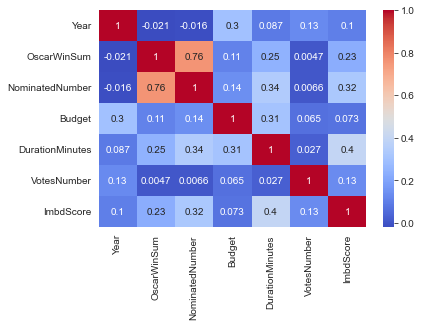

In [70]:
corr = movies[factors].corr()
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sb.color_palette("coolwarm", as_cmap=True))



Як бачимо, мультиколінеарними є кількість виграних номінацій у Оскарі та загальна кількість номінацій Оскару. Видалимо кількість номінацій

<AxesSubplot:>

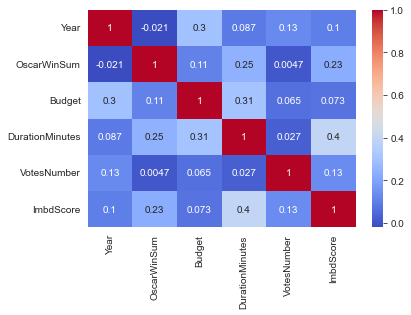

In [71]:
movies.drop(['NominatedNumber'], axis=1, inplace=True)
factors.remove('NominatedNumber')

corr = movies[factors].corr()
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sb.color_palette("coolwarm", as_cmap=True))

Сформуємо набори даних факторів та відгуку

In [73]:
X = movies[factors]
Y = movies[[response]]

Перетворимо жанри у dummy variables:

In [74]:
res = X['Genres'].str.get_dummies(sep='-').add_prefix('genres_')

X = pd.concat([X, res], axis = 1)
X.drop(columns=['Genres'], inplace=True)
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              7374 non-null   int64  
 1   OscarWinSum       7374 non-null   int64  
 2   Budget            7374 non-null   float64
 3   DurationMinutes   7374 non-null   float64
 4   VotesNumber       7374 non-null   float64
 5   ImbdScore         7374 non-null   float64
 6   RatingName        7374 non-null   object 
 7   genres_Action     7374 non-null   int64  
 8   genres_Adventure  7374 non-null   int64  
 9   genres_Animation  7374 non-null   int64  
 10  genres_Biography  7374 non-null   int64  
 11  genres_Comedy     7374 non-null   int64  
 12  genres_Crime      7374 non-null   int64  
 13  genres_Drama      7374 non-null   int64  
 14  genres_Family     7374 non-null   int64  
 15  genres_Fantasy    7374 non-null   int64  
 16  genres_Fi         7374 non-null   int64  


,Year,OscarWinSum,Budget,DurationMinutes,VotesNumber,ImbdScore,RatingName,genres_Action,genres_Adventure,genres_Animation,...,genres_Mystery,genres_Reality,genres_Romance,genres_Sci,genres_Show,genres_Sport,genres_TV,genres_Thriller,genres_War,genres_Western
2,1987,0,25000000.0,106.0,32000000.0,6.7,PG,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2009,0,5600000.0,85.0,70000000.0,6.5,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2016,0,15000000.0,103.0,306304.0,7.2,PG-13,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1999,0,30000000.0,97.0,315247.0,7.3,PG-13,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,1983,0,4520000.0,101.0,7200000.0,6.3,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Аналогічно перетворимо віковий рейтинг:

In [75]:
ageRating = X['RatingName'].str.get_dummies().add_prefix('AgeRating_')

X = pd.concat([X, ageRating], axis = 1)
X.drop(columns=['RatingName'], inplace=True)
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                7374 non-null   int64  
 1   OscarWinSum         7374 non-null   int64  
 2   Budget              7374 non-null   float64
 3   DurationMinutes     7374 non-null   float64
 4   VotesNumber         7374 non-null   float64
 5   ImbdScore           7374 non-null   float64
 6   genres_Action       7374 non-null   int64  
 7   genres_Adventure    7374 non-null   int64  
 8   genres_Animation    7374 non-null   int64  
 9   genres_Biography    7374 non-null   int64  
 10  genres_Comedy       7374 non-null   int64  
 11  genres_Crime        7374 non-null   int64  
 12  genres_Drama        7374 non-null   int64  
 13  genres_Family       7374 non-null   int64  
 14  genres_Fantasy      7374 non-null   int64  
 15  genres_Fi           7374 non-null   int64  
 16  genres

,Year,OscarWinSum,Budget,DurationMinutes,VotesNumber,ImbdScore,genres_Action,genres_Adventure,genres_Animation,genres_Biography,...,AgeRating_GP,AgeRating_NC-17,AgeRating_PG,AgeRating_PG-13,AgeRating_Passed,AgeRating_R,AgeRating_TV-14,AgeRating_TV-MA,AgeRating_TV-PG,AgeRating_X
2,1987,0,25000000.0,106.0,32000000.0,6.7,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2009,0,5600000.0,85.0,70000000.0,6.5,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,2016,0,15000000.0,103.0,306304.0,7.2,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,1999,0,30000000.0,97.0,315247.0,7.3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,1983,0,4520000.0,101.0,7200000.0,6.3,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [31]:
# import scipy.stats as st
#
# columns = [
#     'budget',
#     'runtime',
#     'vote_average',
#     'year'
# ]
#
# for column in columns:
#     _, p = st.kstest(X[column], 'norm')
#     if p > 0.05:
#         print(column + ' should be removed from analysis')
#     else:
#         print(column + ' is important factor')

Розділимо дані на навчальні та тестові, 30% буде віднесено до тестової вибірки

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 5)

Створимо модель лінійної регресії:

In [56]:
LinReg = LinearRegression().fit(X_train, Y_train)

Створимо моделі поліноміальної регресії степенів 2 та 3:

In [77]:
PolReg2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
PolReg2.fit(X_train, Y_train)

PolReg3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
PolReg3.fit(X_train, Y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [78]:
models = [LinReg,
          PolReg2,
          PolReg3]

In [83]:
RSE_scores = []
R2_scores = []
MSE_scores = []
RMSE_scores = []

for model in models:
    y_true = np.array(Y_test)
    y_predicted = np.array(model.predict(X_test))
    RSE_scores.append(sqrt((np.sum(np.square(y_true - y_predicted)))/(len(y_true) - 2)))
    R2_scores.append(r2_score(y_true, y_predicted))

    mse = np.mean(np.square(y_true - y_predicted))
    MSE_scores.append(mse)
    RMSE_scores.append(np.sqrt(mse))

    # y_pred = model.predict(X_test)
    # plt.hist(y_pred, color ='k')
    # plt.hist(Y_test, color ='b')
    #
    # plt.show()
    #
    #
    # plt.figure(figsize=(10,10))
    # plt.scatter(Y_test, y_predicted, c='crimson')
    # plt.yscale('log')
    # plt.xscale('log')
    #
    # p1 = max(max(y_predicted), max(y_true))
    # p2 = min(min(y_predicted), min(y_true))
    # plt.plot([p1, p2], [p1, p2], 'b-')
    # plt.xlabel('True Values', fontsize=15)
    # plt.ylabel('Predictions', fontsize=15)
    # plt.axis('equal')
    # plt.show()
    #
    #
    # plt.plot(y_true - y_pred,marker='o',linestyle='')
    # plt.show()

print('R2: ', R2_scores)
print('RSE: ', RSE_scores)
print('MSE: ', MSE_scores)
print('RMSE: ', RMSE_scores)
print('RSE index min: ', np.argmin(RSE_scores) +1, RSE_scores[np.argmin(RSE_scores)])
print('R2 index max: ', np.argmax(R2_scores) + 1, R2_scores[np.argmax(R2_scores)])

R2:  [0.6231269931728914, -0.26392756615479285, -2.602001313166954]
RSE:  [95931458.17399617, 175680930.2810156, 296575630.91137326]
MSE:  [9194527591322852.0, 3.0835896097422132e+16, 8.787761356728843e+16]
RMSE:  [95888099.32062921, 175601526.46666297, 296441585.4216281]
RSE index min:  1 95931458.17399617
R2 index max:  1 0.6231269931728914


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                7374 non-null   float64
 1   OscarWinSum         7374 non-null   float64
 2   Budget              7374 non-null   float64
 3   DurationMinutes     7374 non-null   float64
 4   VotesNumber         7374 non-null   float64
 5   ImbdScore           7374 non-null   float64
 6   genres_Action       7374 non-null   float64
 7   genres_Adventure    7374 non-null   float64
 8   genres_Animation    7374 non-null   float64
 9   genres_Biography    7374 non-null   float64
 10  genres_Comedy       7374 non-null   float64
 11  genres_Crime        7374 non-null   float64
 12  genres_Drama        7374 non-null   float64
 13  genres_Family       7374 non-null   float64
 14  genres_Fantasy      7374 non-null   float64
 15  genres_Fi           7374 non-null   float64
 16  genres

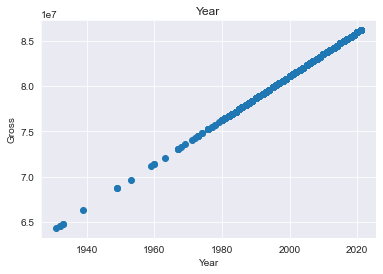

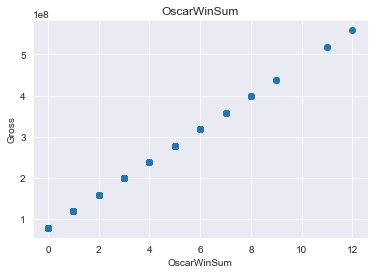

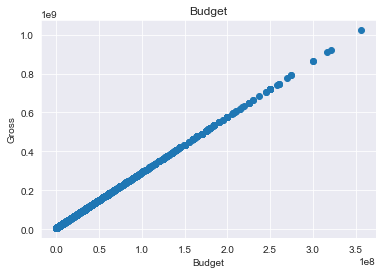

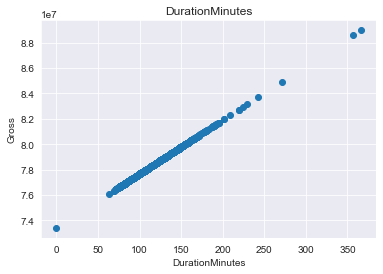

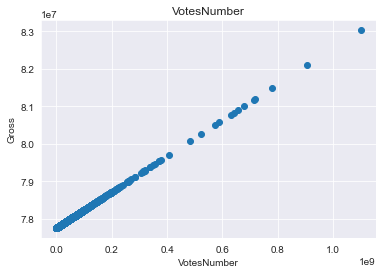

In [81]:
columnsDisplay = ['Year', 'OscarWinSum', 'Budget', 'DurationMinutes', 'VotesNumber'] # 'NominatedNumber', 'Gross'

fixedValue = X.iloc[0]

fixed_df = X.copy(deep = True)
for column in X.columns:
    fixed_df[column] = fixedValue[column]

print(fixed_df.info())

for column in columnsDisplay:
    fixed_with_column = fixed_df.copy(deep = True)
    fixed_with_column[column] = X[column]
    yPred = LinReg.predict(fixed_with_column)
    plt.figure()
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel(response)
    plt.scatter(fixed_with_column[column], yPred)
    plt.show()

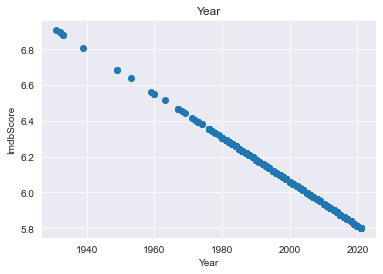

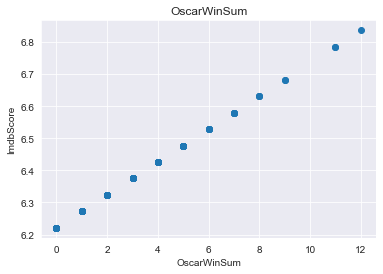

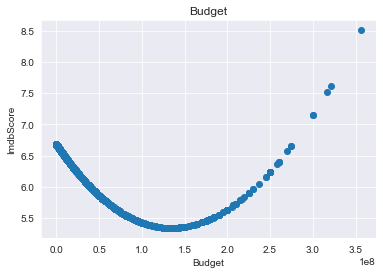

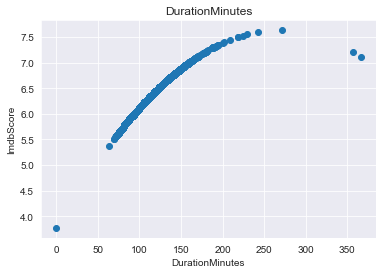

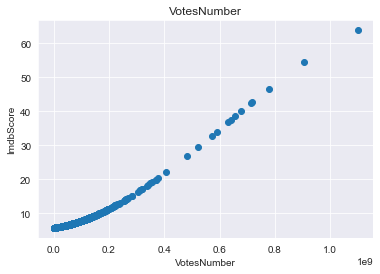

In [38]:
for column in columnsDisplay:
    fixed_with_column = fixed_df.copy(deep = True)
    fixed_with_column[column] = X[column]
    yPred = PolReg3.predict(fixed_with_column)
    plt.figure()
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('ImdbScore')
    plt.scatter(fixed_with_column[column], yPred)
    plt.show()

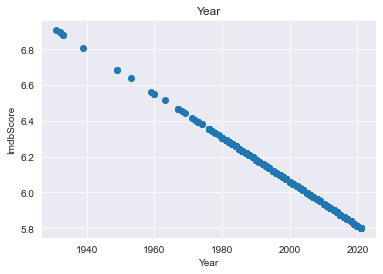

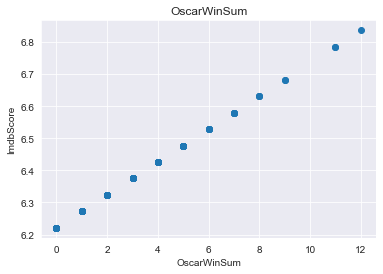

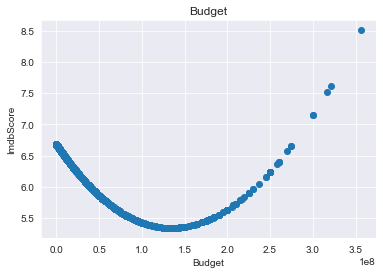

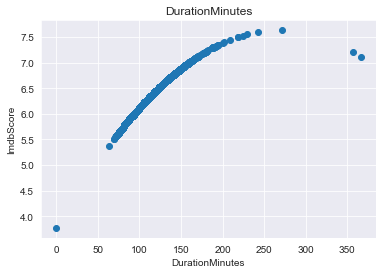

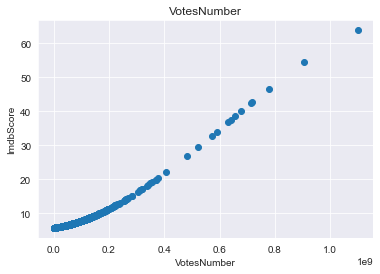

In [39]:
for column in columnsDisplay:
    fixed_with_column = fixed_df.copy(deep = True)
    fixed_with_column[column] = X[column]
    yPred = PolReg3.predict(fixed_with_column)
    plt.figure()
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('ImdbScore')
    plt.scatter(fixed_with_column[column], yPred)
    plt.show()

In [40]:

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(Y)


X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_std, y_std, test_size=0.3, random_state=0)

X_train_scaled.std(), X_train_scaled.mean()

(1.028876820255751, -0.0009422946845148781)

In [41]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train_scaled)
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)
print(lasso.coef_)

print('R^2 test: {:.3f}'.format(r2_score(y_test_scaled, y_test_pred)))

[-0.          0.05331527  0.0219105   0.24654964  0.         -0.
  0.          0.03277664  0.02298523 -0.          0.          0.09232964
  0.         -0.          0.         -0.          0.         -0.
  0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.
 -0.         -0.          0.          0.          0.          0.
  0.        ]
R^2 test: 0.207


In [42]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train_scaled)
y_train_pred = ridge.predict(X_train_scaled)
y_test_pred = ridge.predict(X_test_scaled)
print(ridge.coef_)

print('R^2 test: {:.3f}'.format(r2_score(y_test_scaled, y_test_pred)))

[[-0.15442366  0.10249684  0.22461252  0.31833793  0.00640735 -0.00579901
   0.12565451  0.21482837  0.14418116  0.12274905  0.09991015  0.2087479
   0.044866    0.0278146   0.04853523 -0.00656847 -0.00961514 -0.06475866
   0.02954489 -0.01206724  0.03814655 -0.00656847  0.05349657  0.04853523
  -0.00656847  0.04971367 -0.00656847  0.07580385  0.03491794  0.02621214
  -0.00342129 -0.0032873  -0.01251606 -0.00558632  0.01225848 -0.04210228
  -0.03286356  0.00115255  0.06304845  0.00667897  0.00448784  0.01581195
   0.00518956]]
R^2 test: 0.298


c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


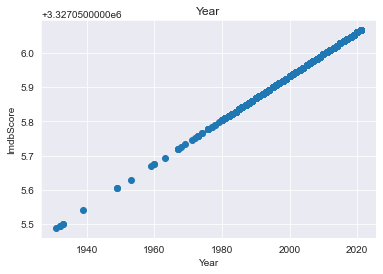

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


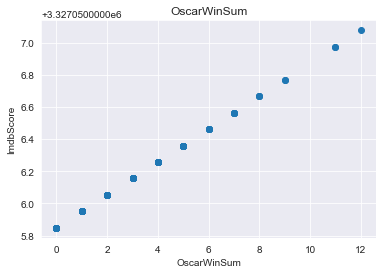

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


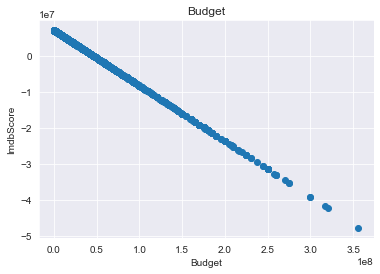

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


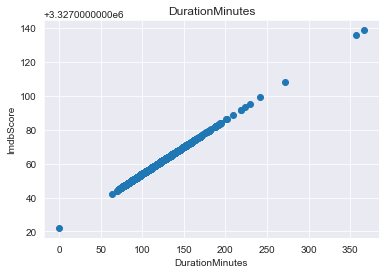

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


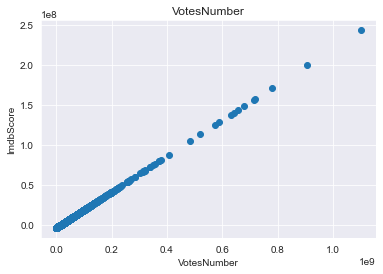

In [43]:
for column in columnsDisplay:
    fixed_with_column = fixed_df.copy(deep = True)
    fixed_with_column[column] = X[column]
    RidgePred = ridge.predict(fixed_with_column)
    plt.figure()
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('ImdbScore')
    plt.scatter(fixed_with_column[column], RidgePred)
    plt.show()

In [44]:
en = ElasticNet(alpha=0.1, l1_ratio=0.5)
en.fit(X_train_scaled, y_train_scaled)
y_train_pred = en.predict(X_train_scaled)
y_test_pred = en.predict(X_test_scaled)
print(en.coef_)

print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train_scaled, y_train_pred),
        r2_score(y_test_scaled, y_test_pred)))

[-0.          0.08492443  0.08072683  0.25980533  0.         -0.01727051
  0.          0.09195153  0.06556976  0.          0.03261879  0.13238816
  0.          0.          0.         -0.         -0.         -0.0141311
  0.          0.          0.         -0.          0.00664192  0.
 -0.          0.         -0.          0.          0.          0.
 -0.          0.          0.         -0.          0.         -0.
 -0.         -0.          0.02983062  0.          0.          0.
  0.        ]
R^2 train: 0.243, test: 0.261
